# CN7050-Intelligent Systems
###**Reinforcement Learning Lab Tutorial**


## Lab Tasks:

Explore the given routing problems and understand how to construct value and policy matrix and how to train and test RL model.
After exploring the given problem, go to the lab tasks at the end of this notebook to try the same code with the different routing problem.

**Reinforcement Learning:**

Practice RL by using the a simple routing example, as shown below. It contains seven nodes (0-6), called states, and the aim is to choose the best route to go from the Start state (0) to the Goal state (6).

The value 0 means it is possible to go from one state to another state, for example, from state 0 to state 1, from state 1 to state 2, and so on. The value -1 means it is not possible, for example, from state 0 to state 3, or from state 2 to state 6, and so on. The value 100 indicates reaching the Goal state; there are only two possibilities, from state 3 to state 6, and from state 6 to state 6.


## Modified from:
- https://amunategui.github.io/reinforcement-learning/index.html
- http://firsttimeprogrammer.blogspot.com/2016/09/getting-ai-smarter-with-q-learning.html
- http://mnemstudio.org/path-finding-q-learning-tutorial.htm


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pylab as plt

# map cell to cell, add circular cell to goal point
#points_list = [(0,1), (1,5), (5,6), (5,4), (1,2), (2,3), (2,7)]

In [3]:
points_list = [(0,1),(1,2),(1,3),(2,4),(3,5),(3,6)]


In [4]:
goal = 6
# goal = 7

In [5]:
import networkx as nx

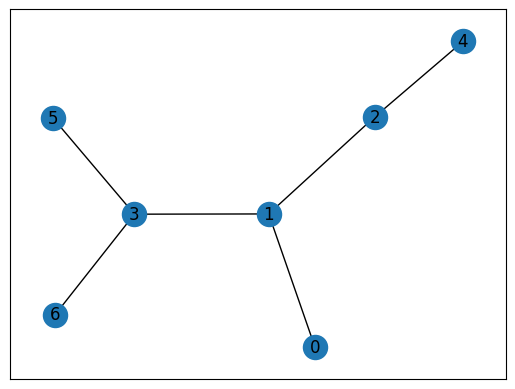

In [6]:
G = nx.Graph()
G.add_edges_from(points_list)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
plt.show()


We then create the rewards graph - this is the matrix version of our list of points map. We initialize the matrix to be the height and width of our points list (7 in this example) and initialize all values to -1


In [7]:
# how many points in graph? x points
MATRIX_SIZE = 7


In [9]:
# create matrix x*y or Value Matrix
R = np.matrix(np.ones(shape=(MATRIX_SIZE, MATRIX_SIZE)))
# print(R)
R *= -1
print(R)

[[-1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]]


We then change the values to be 0 if it is a viable path and 100 if it is a goal path

In [10]:
print(points_list)

[(0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (3, 6)]


In [11]:
# assign zeros to paths and 100 to goal-reaching point
for point in points_list:
  print(point)

  if point[1] == goal:
    R[point] = 100
  else:
    R[point] = 0


  if point[0] == goal:
    R[point[::-1]] = 100
  else:
    # reverse of point
    R[point[::-1]] = 0

# add goal point round trip
R[goal, goal] = 100


(0, 1)
(1, 2)
(1, 3)
(2, 4)
(3, 5)
(3, 6)


In [12]:
# display value matrix
R

matrix([[ -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [  0.,  -1.,   0.,   0.,  -1.,  -1.,  -1.],
        [ -1.,   0.,  -1.,  -1.,   0.,  -1.,  -1.],
        [ -1.,   0.,  -1.,  -1.,  -1.,   0., 100.],
        [ -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,   0.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,   0.,  -1.,  -1., 100.]])

To read the above matrix, the y-axis is the state or where your bot is currently located, and the x-axis is your possible next actions.

Based on the reward matrix R you can also construct a similar matrix **Q (Policy Matrix)**, which will hold all the lessons learned from our bot.

The Q-learning model uses a transitional rule formula to update the values of matrix Q iteratively and **gamma** is the `learning parameter/ discount facttor`.



The formula basically says the value of matrix Q at state (s) and action (a) is equal to the sum of the corresponding value in matrix R and the learning parameter gamma, multiplied by the maximum value of matrix Q for all possible actions in the next state.

In [17]:
# Create Q Matrix
Q = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))

#Creates a Q-matrix filled with zeros. This matrix will be updated during learning, with rows representing states and columns representing actions.

## Learning parameter/discount factor
gamma = 0.8

initial_state = 1
#This sets the starting point for the agent's learning to state 1.

#Define available_actions Function:
def available_actions(state):
  current_state_row = R[state,]
  print(f'current-state-row:',current_state_row)
  av_act = np.where(current_state_row >= 0)[1]
  print(f'av-act:',av_act)
  return av_act

  #Given a state, the above function identifies all possible actions by checking the corresponding row in the reward matrix R.
  #Actions with non-negative values in R are considered "available."

available_act = available_actions(initial_state)

#define a function to Randomly selects an action from the list of available actions, helping the agent explore the environment.

def sample_next_action(available_actions_range):
  next_action = int(np.random.choice(available_act, 1))
  print(f'next action:',next_action)
  return next_action

action = sample_next_action(available_act)



current-state-row: [[ 0. -1.  0.  0. -1. -1. -1.]]
av-act: [0 2 3]
next action: 2


In [15]:
print(action)

2


Define update function for updating the Q-matrix for the selected state-action pair: Finds the highest Q-value from the next state and uses it to calculate the reward for the current state-action. Updates the Q-value at (current_state, action) with the Bellman equation: Q(s, a) = R(s, a) + γ * max(Q(s’, a’)). Normalizes and returns the sum of Q-values for monitoring progress if Q has non-zero values.

In [19]:
def update(current_state, action, gamma):
  max_index = np.where(Q[action,] == np.max(Q[action,]))[1]
  print(f'max-index:', max_index)

  if max_index.shape[0] > 1:
    max_index = int(np.random.choice(max_index, size=1))
    print(f'max-index:', max_index)
  else:
    max_index = int(max_index)
  max_value = Q[action, max_index]

  Q[current_state, action] = R[current_state, action] + gamma * max_value
  print('max_value', R[current_state, action] + gamma * max_value)

  if (np.max(Q) > 0):
    return(np.sum(Q/np.max(Q)*100))
  else:
    return (0)

update(initial_state, action, gamma)


max-index: [0 1 2 3 4 5 6]
max-index: 1
max_value 0.0


0

We run the training and testing functions that will run the update function 700 times allowing the Q-learning model to figure out the most efficient path

In [20]:
# Training
scores = []
for i in range(700):
  current_state = np.random.randint(0, int(Q.shape[0]))
  available_act = available_actions(current_state)
  action = sample_next_action(available_act)
  score = update(current_state, action, gamma)
  scores.append(score)
  print('Scores:', str(score))

print("Trained Q matrix:")
print(Q/np.max(Q)*100)


current-state-row: [[ -1.  -1.  -1.   0.  -1.  -1. 100.]]
av-act: [3 6]
next action: 6
max-index: [0 1 2 3 4 5 6]
max-index: 5
max_value 100.0
Scores: 100.0
current-state-row: [[-1.  0. -1. -1.  0. -1. -1.]]
av-act: [1 4]
next action: 1
max-index: [0 1 2 3 4 5 6]
max-index: 5
max_value 0.0
Scores: 100.0
current-state-row: [[ 0. -1.  0.  0. -1. -1. -1.]]
av-act: [0 2 3]
next action: 2
max-index: [0 1 2 3 4 5 6]
max-index: 0
max_value 0.0
Scores: 100.0
current-state-row: [[ -1.   0.  -1.  -1.  -1.   0. 100.]]
av-act: [1 5 6]
next action: 1
max-index: [0 1 2 3 4 5 6]
max-index: 4
max_value 0.0
Scores: 100.0
current-state-row: [[-1.  0. -1. -1. -1. -1. -1.]]
av-act: [1]
next action: 1
max-index: [0 1 2 3 4 5 6]
max-index: 0
max_value 0.0
Scores: 100.0
current-state-row: [[-1.  0. -1. -1.  0. -1. -1.]]
av-act: [1 4]
next action: 1
max-index: [0 1 2 3 4 5 6]
max-index: 0
max_value 0.0
Scores: 100.0
current-state-row: [[-1.  0. -1. -1. -1. -1. -1.]]
av-act: [1]
next action: 1
max-index: [0 1 

Most efficient path:
[0, 1, 3, 6]


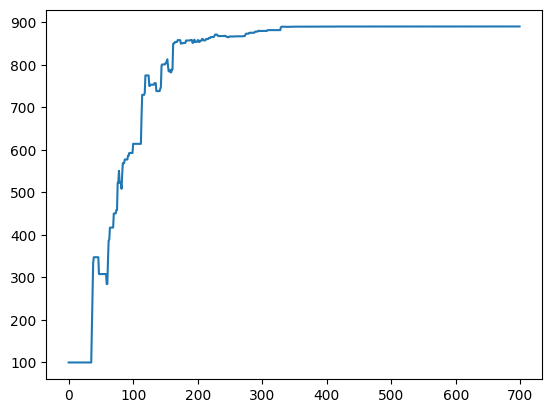

In [21]:
# Testing
current_state = 0
steps = [current_state]

while current_state != 6: ## use 6 and 7

    next_step_index = np.where(Q[current_state,] == np.max(Q[current_state,]))[1]

    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size = 1))
    else:
        next_step_index = int(next_step_index)

    steps.append(next_step_index)
    current_state = next_step_index

print("Most efficient path:")
print(steps)

plt.plot(scores)
plt.show()


We see that the model did correctly find the most efficient path from the starting node 0 to the goal node 6 and took around 200 iterations to converge to a solution.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!jupyter nbconvert --to html '/content/drive/MyDrive/UEL-Intelligence-System-Lab/Lab-4/Reinforcement Learning.ipynb'


[NbConvertApp] Converting notebook /content/drive/MyDrive/UEL-Intelligence-System-Lab/Lab-4/Reinforcement Learning.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 379213 bytes to /content/drive/MyDrive/UEL-Intelligence-System-Lab/Lab-4/Reinforcement Learning.html
